<a href="https://colab.research.google.com/github/MaricelaMH/SIMULACION-II/blob/main/PRUEBA_ART_SIMU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulación de nuestro sistema de transporte púlico combis.

In [4]:
# Intalamos la libreria simpy
!pip install simpy

In [5]:
#Agregamos nuestras librerias a usar
import simpy
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Parámetros del sistema
TASA_LLEGADAS_PROM = 0.72  # Pasajeros por minuto
TIEMPO_SERVICIO_PROM = 0.21  # Promedio de minutos para abordar un pasajero
NUM_COMBIS_BASE = 1  # Número de combis
CAPACIDAD_COMBI = 19  # Capacidad máxima de pasajeros por combi

In [7]:
# Registro de métricas
rho_valores = []
tiempo_actual = []
tiempo_promedio_espera = []
tiempo_promedio_abordaje = []
porcentaje_ocupacion = []

tiempo_llegadas = []
tiempo_abordajes = []
ocupacion_actual = []

In [8]:
# Función para ajustar el número de combis según el intervalo de tiempo
def ajustar_combis(env, tiempo_actual):
    if 18 <= tiempo_actual <= 19:  # Intervalo de alta demanda ( Ejemplo. 6:00 p.m. - 7:00 p.m.)
        return 3  # Aumentamos el número de combis en el intervalo
    else:
        return NUM_COMBIS_BASE

In [9]:
# Función que simula el servicio de una combi (servidor)
def servicio_combi(env, combi_id, cola):
    capacidad = CAPACIDAD_COMBI
    while True:
        yield cola.get()  # Pasajero abordando
        tiempo_abordajes.append(env.now)  # Registro del tiempo de abordaje
        ocupacion_actual.append(1 - capacidad / CAPACIDAD_COMBI)
        capacidad -= 1

        # Si la combi está llena
        if capacidad == 0 or len(cola.items) == 0:
            capacidad = CAPACIDAD_COMBI  # Reiniciar capacidad
            yield env.timeout(np.random.exponential(5))  # Tiempo de salida
        yield env.timeout(np.random.exponential(TIEMPO_SERVICIO_PROM))

In [10]:
# Función para generar la llegada de pasajeros
def llegada_pasajeros(env, cola):
    while True:
        yield env.timeout(np.random.exponential(TASA_LLEGADAS_PROM))
        tiempo_llegadas.append(env.now)  # Registro del tiempo de llegada
        cola.put(1)  # Pasajero llega a la cola

In [11]:
# Función para registrar resultados
def registrar_resultados(env):
    while True:
        yield env.timeout(1)  # Registrar resultados cada minuto
        if tiempo_llegadas and tiempo_abordajes:
            tiempos_espera = [abordaje - llegada for llegada, abordaje in zip(tiempo_llegadas, tiempo_abordajes)]
            tiempo_actual.append(env.now)
            tiempo_promedio_espera.append(np.mean(tiempos_espera))

            # Calcular el tiempo promedio de abordaje
            if len(tiempo_abordajes) > 1:  # Asegurar suficientes datos para calcular la diferencia
                tiempo_promedio_abordaje.append(np.mean(np.diff(tiempo_abordajes[-CAPACIDAD_COMBI:])))
            else:
                tiempo_promedio_abordaje.append(0)  # Valor por defecto si no hay suficientes datos

            # Calcular el porcentaje de ocupación promedio
            if ocupacion_actual:
                porcentaje_ocupacion.append(np.mean(ocupacion_actual) * 100)

        # Calcular rho dinámicamente
        lambda_actual = 1 / TASA_LLEGADAS_PROM  # Tasa promedio de llegadas
        mu_actual = 1 / TIEMPO_SERVICIO_PROM   # Tasa promedio de servicio
        num_combis = ajustar_combis(env, env.now)  # Número actual de combis
        if num_combis > 0:
            rho_valor = lambda_actual / (mu_actual * num_combis)
            rho_valores.append(rho_valor)

In [12]:
# Función para simular el sistema
def simulacion():
    env = simpy.Environment()
    cola = simpy.Store(env)  # Cola de pasajeros esperando

    # Iniciar procesos
    env.process(llegada_pasajeros(env, cola))
    for i in range(NUM_COMBIS_BASE):
        env.process(servicio_combi(env, i, cola))
    env.process(registrar_resultados(env))

    # Ejecutar simulación por 60 minutos
    env.run(until=60)

    # Visualizar resultados
    graficar_convergencia()

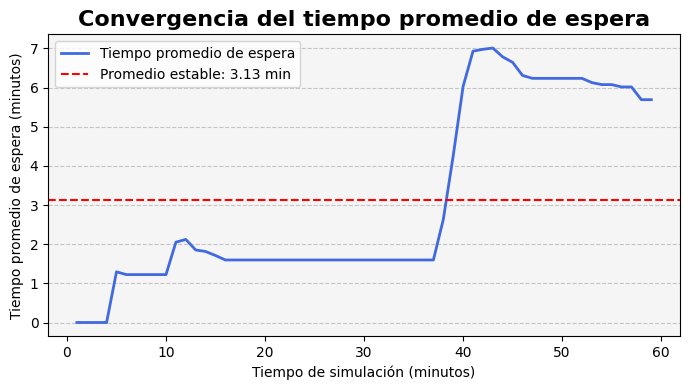

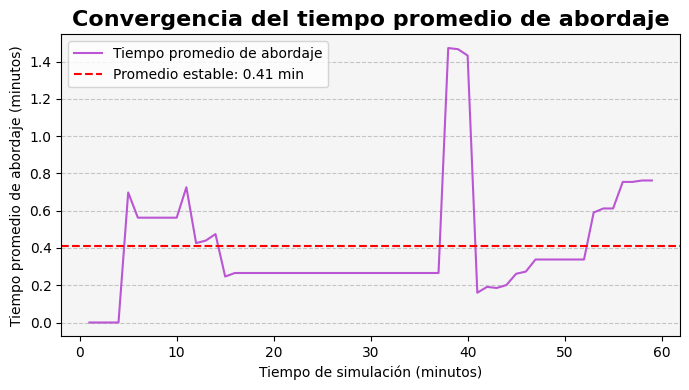

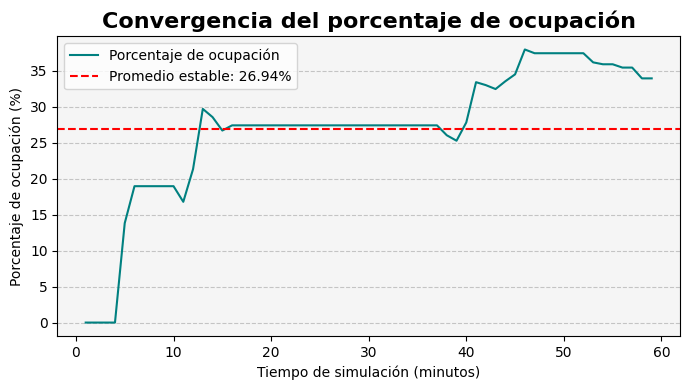

In [13]:
# Función para graficar las métricas de convergencia
def graficar_convergencia():
    # Gráfico del tiempo promedio de espera
    plt.figure(figsize=(7, 4))
    plt.plot(tiempo_actual, tiempo_promedio_espera, label="Tiempo promedio de espera", color="#4169E1",linewidth=2)
    plt.title("Convergencia del tiempo promedio de espera",fontsize=16, fontweight='bold')
    plt.xlabel("Tiempo de simulación (minutos)")
    plt.ylabel("Tiempo promedio de espera (minutos)")
    promedio_espera = np.mean(tiempo_promedio_espera)
    plt.axhline(y=promedio_espera, color='red', linestyle='--', label=f"Promedio estable: {promedio_espera:.2f} min")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().set_facecolor('#F5F5F5')
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Gráfico del tiempo promedio de abordaje
    plt.figure(figsize=(7, 4))
    plt.plot(tiempo_actual, tiempo_promedio_abordaje, label="Tiempo promedio de abordaje", color="#BA55D3")
    plt.title("Convergencia del tiempo promedio de abordaje",fontsize=16, fontweight='bold')
    plt.xlabel("Tiempo de simulación (minutos)")
    plt.ylabel("Tiempo promedio de abordaje (minutos)")
    promedio_abordaje = np.mean(tiempo_promedio_abordaje)
    plt.axhline(y=promedio_abordaje, color='red', linestyle='--', label=f"Promedio estable: {promedio_abordaje:.2f} min")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().set_facecolor('#F5F5F5')
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Gráfico del porcentaje de ocupación
    plt.figure(figsize=(7, 4))
    plt.plot(tiempo_actual, porcentaje_ocupacion, label="Porcentaje de ocupación", color="#008080")
    plt.title("Convergencia del porcentaje de ocupación",fontsize=16, fontweight='bold')
    plt.xlabel("Tiempo de simulación (minutos)")
    plt.ylabel("Porcentaje de ocupación (%)")
    promedio_ocupacion = np.mean(porcentaje_ocupacion)
    plt.axhline(y=promedio_ocupacion, color='red', linestyle='--', label=f"Promedio estable: {promedio_ocupacion:.2f}%")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().set_facecolor('#F5F5F5')
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# Correr la simulación
simulacion()